In [4]:
#install required packages
!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-1.11.0+cu113.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-1.11.0+cu113.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

In [5]:
# helper function for visualization
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def visualize(h, color):
  z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())

  plt.figure(figsize = (10, 10))
  plt.xticks([])
  plt.yticks([])

  plt.scatter(z[:, 0], z[:, 1], s = 70, c = color, cmap = 'Set2')
  plt.show()

In [18]:
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures

def data(name):
  dataset = Planetoid(root = "data/Planetoid", name = f"{name}", transform = NormalizeFeatures())
  return dataset
dataset = data("Citeseer") # chnage dataset type
print(dataset) 

print("---"*36)
print(f'length of the dataset: {len(dataset)}')
print(f'features in the dataset: {dataset.num_features}')
print(f'Number of classes in the dataset: {dataset.num_classes}')
print("---"*36)
data = dataset[0]
print('print dataset properties')
print(data)

print(f'Number of nodes in the dataset: {data.num_nodes}')
print(f'Number of edges in the dataset: {data.num_edges}')
print(f'Average Node degree: {data.num_edges/data.num_nodes:0.2f}')
print(f'number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {data.train_mask.sum()/data.num_nodes:0.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

Processing...
Done!


Citeseer()
------------------------------------------------------------------------------------------------------------
length of the dataset: 1
features in the dataset: 3703
Number of classes in the dataset: 6
------------------------------------------------------------------------------------------------------------
print dataset properties
Data(x=[3327, 3703], edge_index=[2, 9104], y=[3327], train_mask=[3327], val_mask=[3327], test_mask=[3327])
Number of nodes in the dataset: 3327
Number of edges in the dataset: 9104
Average Node degree: 2.74
number of training nodes: 120
Training node label rate: 0.04
Has isolated nodes: True
Has self-loops: False
Is undirected: True


In [19]:
from torch_geometric.nn import SAGEConv
import torch.nn.functional as F
import torch
class SAGE(torch.nn.Module):
  def __init__(self, in_channels, hidden_channels):
    super().__init__()
    torch.manual_seed(1234567)
    self.conv1 = SAGEConv(in_channels, hidden_channels)
    self.conv2 = SAGEConv(hidden_channels, dataset.num_classes)


  def forward(self, x, edge_index):
    x = self.conv1(x, edge_index)
    x = x.relu()
    x = F.dropout(x, p = 0.5, training = self.training)
    x = self.conv2(x, edge_index)
    return x
model = SAGE(dataset.num_features, hidden_channels=16)
print(model)

SAGE(
  (conv1): SAGEConv(3703, 16, aggr=mean)
  (conv2): SAGEConv(16, 6, aggr=mean)
)


In [20]:
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))


model = SAGE(dataset.num_features, hidden_channels = 16)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model=model.to(device)
data = data.to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

def train():
  model.train()
  optimizer.zero_grad()
  out = model(data.x, data.edge_index)
  loss = criterion(out[data.train_mask], data.y[data.train_mask])
  loss.backward()
  optimizer.step()
  return loss


def test():
  model.eval()
  out = model(data.x, data.edge_index)
  pred = out.argmax(dim=1)
  corrects = pred[data.test_mask] == data.y[data.test_mask]
  test_acc = int(corrects.sum())/int(data.test_mask.sum())
  return test_acc

for epoch in range(1, 101):
    loss = train()
    if epoch %10 == 0:
      print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

<IPython.core.display.Javascript object>

Epoch: 010, Loss: 1.6262
Epoch: 020, Loss: 1.2466
Epoch: 030, Loss: 0.8524
Epoch: 040, Loss: 0.5299
Epoch: 050, Loss: 0.4170
Epoch: 060, Loss: 0.3187
Epoch: 070, Loss: 0.3179
Epoch: 080, Loss: 0.2763
Epoch: 090, Loss: 0.2352
Epoch: 100, Loss: 0.2491


In [21]:
test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.6900


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


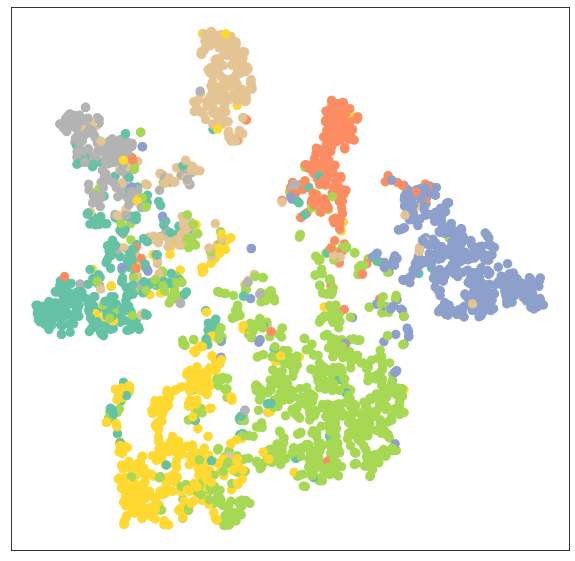

In [12]:
model.eval()

out = model(data.x, data.edge_index).cpu()
visualize(out, color=data.y.cpu())